# Exploratory data analysis

The goal of this project is to determine the best players to pick for an upcoming gameweek, based upon their previous performance and information about the upcoming fixtures. The primary response variable for this is the number of points a player scores in that game. This combines information about a players performance, including goals, assists, and many other variables. See <a href='https://fantasy.premierleague.com/help/rules'>here</a> for a detailed description of the scoring methodology.

This is quite open-ended, meaning there are several diferent approaches I might take. Some options include:
- predicting players points directly using a linear regression (or similar) approach
- using Poisson regression, seeing how points are a discrete variable which might be modelled as a count
- use a classification framework, predicting who will score over a certain amount of points

This analysis should help to determine the best approach to use, as well as allowing us to explore the data. A priori, I know that this will be a challenging task, as in sports (particularly football), past performance is not indicative of future results! As such, while a regression approach would be most useful in a general-sense, it might be that I have to settle for a classification approach.


- status etc. columns
- GWs should not really be considered as equal but this is an assumption

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
in_file = os.path.join('..', 'data', 's201819', 'cleaned', 'player_gameweek_data_GW371564330379.csv')
player_data = pd.read_csv(in_file)
player_data.head()

,player_id,first_name,second_name,position,team_id,team_short,team_name,team_difficulty,gameweek,kickoff_time,kickoff_hour,kickoff_hour_cos,kickoff_hour_sin,kickoff_hour_bin,kickoff_weekday,kickoff_weekday_cos,kickoff_weekday_sin,event_day,fixture_id,is_home,opponent_team,opponent_team_short,opponent_team_name,opponent_team_strength,opponent_difficulty,opponent_strength_ha_overall,opponent_strength_ha_attack,opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,value,value_change,custom_form,transfers_balance,transfers_in,transfers_out,team_strength,team_strength_ha_overall,team_strength_ha_attack,team_strength_ha_defence,chance_of_playing_next_round,chance_of_playing_this_round,finished,kickoff_datetime,news,next_game,prev_assists,prev_attempted_passes,prev_big_chances_created,prev_big_chances_missed,prev_bonus,prev_bps,prev_clean_sheets,prev_clearances_blocks_interceptions,prev_completed_passes,prev_creativity,prev_draw,prev_dribbles,prev_ea_index,prev_errors_leading_to_goal,prev_errors_leading_to_goal_attempt,prev_fouls,prev_goals_conceded,prev_goals_scored,prev_ict_index,prev_influence,prev_key_passes,prev_kickoff_datetime,prev_kickoff_hour,prev_kickoff_hour_bin,prev_kickoff_hour_cos,prev_kickoff_hour_sin,prev_kickoff_time,prev_kickoff_time_formatted,prev_kickoff_weekday,prev_kickoff_weekday_cos,prev_kickoff_weekday_sin,prev_loss,prev_minutes,prev_offside,prev_open_play_crosses,prev_opponent_score,prev_opponent_team,prev_own_goals,prev_penalties_conceded,prev_penalties_missed,prev_penalties_saved,prev_playergw_id,prev_recoveries,prev_red_cards,prev_saves,prev_tackled,prev_tackles,prev_target_missed,prev_team_score,prev_threat,prev_total_points,prev_win,prev_winning_goals,prev_yellow_cards,roll_goals_scored,roll_mean_points,roll_minutes,roll_team_conceded,roll_team_points,roll_team_scored,roll_total_points,roll_unique_scorers,started,status,team_prev_mean_points,team_prev_result_points,team_prev_total_points,team_prev_unique_scorers
0,1,Petr,Cech,GKP,1,ARS,Arsenal,4,1,2018-08-12T15:00:00Z,15,-0.707107,-7.071068e-01,afternoon,6,0.623490,-0.781831,3,1,True,13,MCI,Man City,5.0,4,1320.0,1320.0,1340.0,3.0,90.0,0.0,2.0,70767.0,50.0,NaN,NaN,0.0,0.0,0.0,4.0,1260.0,1240.0,1310.0,NaN,NaN,True,2018-08-12 15:00:00,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,evening,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
1,1,Petr,Cech,GKP,1,ARS,Arsenal,4,2,2018-08-18T16:30:00Z,16,-0.500000,-8.660254e-01,afternoon,5,-0.222521,-0.974928,1,14,False,6,CHE,Chelsea,4.0,4,1310.0,1340.0,1330.0,3.0,90.0,0.0,3.0,90038.0,50.0,0.0,NaN,188.0,6059.0,5871.0,4.0,1320.0,1270.0,1340.0,NaN,NaN,True,2018-08-18 16:30:00,NaN,False,0.0,42.0,0.0,0.0,0.0,24.0,0.0,2.0,31.0,0.0,False,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.7,47.0,0.0,2018-08-12 15:00:00,15.0,afternoon,-0.707107,-7.071068e-01,2018-08-12T15:00:00Z,12 Aug 16:00,6.0,0.623490,-0.781831,True,90.0,0.0,0.0,2.0,13.0,0.0,0.0,0.0,0.0,1.0,9.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,3.0,False,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,1.357143,0.0,19.0,0.0
2,1,Petr,Cech,GKP,1,ARS,Arsenal,3,3,2018-08-25T14:00:00Z,14,-0.866025,-5.000000e-01,midday,5,-0.222521,-0.974928,1,21,True,19,WHU,West Ham,3.0,4,1100.0,1090.0,1120.0,3.0,90.0,0.0,1.0,107301.0,50.0,0.0,NaN,8540.0,19550.0,11010.0,4.0,1260.0,1240.0,1310.0,NaN,NaN,True,2018-08-25 14:00:00,NaN,False,0.0,35.0,0.0,0.0,0.0,26.0,0.0,1.0,25.0,0.0,True,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.3,53.0,0.0,2018-08-18 16:30:00,16.0,afternoon,-0.500000,-8.660254e-01,2018-08-18T16:30:00Z,18 Aug 17:30,5.0,-0.222521,-0.974928,False,90.0,0.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,526.0,8.0,0.0,8.0,0.0,0.0,0.0,2.0,0.0,3.0,False,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,2.428571,0.0,34.0,2.0
3,1,Petr,Cech,GKP,1,ARS,Arsenal,2,4,2018-09-02T12:30:00Z,12,-1.000000,1.22464

In [3]:
display('Shape of the player DataFrame: {}'.format(player_data.shape))

'Shape of the player DataFrame: (21782, 117)'

In [4]:
display('General info regarding the player DataFrame:\n\n')
display(_ = player_data.info())

'General info regarding the player DataFrame:\n\n'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21782 entries, 0 to 21781
Columns: 117 entries, player_id to team_prev_unique_scorers
dtypes: bool(7), float64(84), int64(10), object(16)
memory usage: 18.4+ MB


In [5]:
columns_target_all = [col for col in player_data if col.startswith('target_')]

### Removing rows which are missing data due to 'rolling variables' not being available
The rolling/previous columns require three or one past match per player to have a value. For this reason, I will only consider players' matches from match four onwards. As we can have problems with players appearing midway through the season, I will mark those players without the required data (so as to highlight the matches are in the first three for that player). I will focus on other causes of missing values later on.

In [6]:
missings_per_col = player_data.isna().sum().sort_values(ascending=False)
display(missings_per_col[(missings_per_col > 0) & ~missings_per_col.index.isin(columns_target_all)])

news                                    21599
chance_of_playing_this_round            21289
chance_of_playing_next_round            21288
status                                  21166
custom_form                              1847
roll_goals_scored                        1847
roll_minutes                             1847
roll_team_points                         1583
roll_team_conceded                       1583
roll_mean_points                         1583
roll_team_scored                         1583
roll_total_points                        1583
roll_unique_scorers                      1583
prev_fouls                                616
prev_kickoff_hour_cos                     616
prev_kickoff_hour_sin                     616
prev_kickoff_hour                         616
prev_kickoff_datetime                     616
prev_key_passes                           616
prev_influence                            616
prev_kickoff_time                         616
prev_ict_index                    

These are all variables which are generated using one or more of each player's previous gameweeks. This means that at the very beginning of the season they will not have these available (as no gameweeks have yet been played). The simplest solution is not to use these rows, as the previous results of a player should have a reasonable (though as mentioned above not perfect) chance of at least helping to predict future performance.

Note that the variables at the top are missing for all but the latest player gameweeks, and won't be included in the modelling.

In [7]:
player_data['use_row'] = ~player_data.custom_form.isna()

In [8]:
missings_per_col2 = player_data[player_data['use_row']].isna().sum().sort_values(ascending=False)
display(missings_per_col2[(missings_per_col2 > 0) & ~missings_per_col2.index.isin(columns_target_all)])

news                            19752
chance_of_playing_this_round    19442
chance_of_playing_next_round    19441
status                          19321
dtype: int64

Finally, I will set boolean variables to say whether we are attempting to predict a row (i.e. it doesn't have an available target value as the game is yet to be played), or use it to build the models.

In [9]:
player_data['predict_row'] = player_data.target_total_points.isna()
player_data['model_row'] = ~player_data['predict_row']

### Removing other unneeded data
Similarly, there are several columns in the data which we will not need to include in the modelling process. As mentioned, several columns are only available for a player's latest gameweek (hence not able to be included in the models). Similarly, `status`, `next_game`, `started`, and `finished` are all booleans always equal to the same value, whose only purpose was in the creation of the dataset. Finally, `prev_ea_index` is always zero, so it can be removed.

In [10]:
no_model_cols = ['news', 'chance_of_playing_this_round', 'chance_of_playing_next_round', 'status',
                 'next_game', 'started', 'finished', 'prev_ea_index', 'prev_playergw_id']

player_data = player_data.loc[player_data['use_row'], [col for col in player_data.columns if col not in no_model_cols]]

## Splitting the data
I'm going to start by using a simple splitting scheme, with 20% of the initial data going into a test set to be used to evaluate the final model. The remainder will be used for training and tuning any models.

In [11]:
from sklearn.model_selection import train_test_split

ids_players_all = player_data['player_id'].unique().astype(int)
ids_players_train, ids_players_test = train_test_split(ids_players_all, test_size=0.2) 

print('Number of players per split:')
print('Train: {:.0f}'.format(len(ids_players_train)))
print('Test: {:.0f}'.format(len(ids_players_test)))

print('\nPercentage of players per split:')
print('Train: {:.1%}'.format(len(ids_players_train)/len(ids_players_all)))
print('Test: {:.1%}'.format(len(ids_players_test)/len(ids_players_all)))

players_train = player_data.loc[player_data.player_id.isin(ids_players_train)].copy()
players_test = player_data.loc[player_data.player_id.isin(ids_players_test)].copy()

Number of players per split:
Train: 491
Test: 123

Percentage of players per split:
Train: 80.0%
Test: 20.0%


Remember that there are 30+ games per player so is a reasonably large number of rows to use (not just 492!).

## Data exploration and cleaning
While much of the data has been processed elsewhere in this repo, there are a few more things which I will do now.

### Response variable
Before continuing with our main feature processing, now is a good time to look at the disrtibution of the target variable so we can decide the approach. I am in quite a flexible situation in that I am open to the type of model used - all I want to do is identify players likely to score highly. I could take three approaches:
* **linear regression**: modelling the number of points as a continuous variable
* **Poisson regression**: modelling the number of points as a discrete count variable. I envisage a couple of issues with this. Firstly, lots of players do not play or otherwise receive zero points, which is not supported by these kinds of models (this will to a smaller extent affect linear regression). We can get around this by using zero-inflated models. Secondly, players can receive negative points which is a bit more difficult to take care of.
* **classification**: we could turn this into a problem of classification where we look to predict points above a certain threshold. This might be an easier approach due to the number of zeros (and negatives) in the target variable. However, we would need to select a threshold and, from experience, most players which play recieve between 1 and 3 points, suggesting an unbalanced dataset.

First, in our training set, what do the numbers of points look like?

In [12]:
min_points = players_train.loc[player_data['model_row'], 'target_total_points'].min()
print('Min points in a game: {}'.format(min_points))

max_points = players_train.loc[player_data['model_row'], 'target_total_points'].max()
print('Max points in a game: {}'.format(max_points))

Min points in a game: -4.0
Max points in a game: 23.0


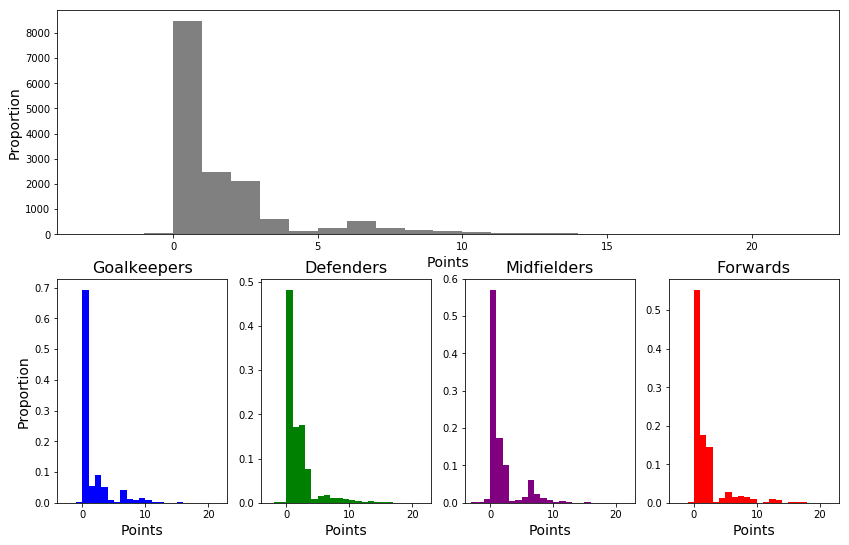

In [13]:
fig = plt.figure(figsize=(14,14))

# Get histogram bins from integers between the min and max points
#nbins = int(max_points-min_points + 1)
nbins = np.arange(min_points, max_points+1)

# Subplots for all players, and then broken down by position
ax_all = plt.subplot2grid((3,4), (0,0), colspan=4)
ax_gkp = plt.subplot2grid((3,4), (1,0))
ax_def = plt.subplot2grid((3,4), (1,1))
ax_mid = plt.subplot2grid((3,4), (1,2))
ax_for = plt.subplot2grid((3,4), (1,3))

ax_all.hist(players_train['target_total_points'].dropna(), bins=nbins, color='grey')
ax_gkp.hist(players_train.loc[players_train['position']=='GKP',
                              'target_total_points'].dropna(), bins=nbins, color='blue', density=True)
ax_mid.hist(players_train.loc[players_train['position']=='DEF',
                              'target_total_points'].dropna(), bins=nbins, color='purple', density=True)
ax_def.hist(players_train.loc[players_train['position']=='MID',
                              'target_total_points'].dropna(), bins=nbins, color='green', density=True)
ax_for.hist(players_train.loc[players_train['position']=='FWD',
                              'target_total_points'].dropna(), bins=nbins, color='red', density=True)

ax_gkp.set_title('Goalkeepers', fontsize=16)
ax_def.set_title('Defenders', fontsize=16)
ax_mid.set_title('Midfielders', fontsize=16)
ax_for.set_title('Forwards', fontsize=16)

for ax in [ax_all, ax_gkp, ax_def, ax_mid, ax_for]:
    ax.set_xlim(min_points, max_points)
    ax.set_xlabel('Points', fontsize=14)

ax_all.set_ylabel('Proportion', fontsize=14)
ax_gkp.set_ylabel('Proportion', fontsize=14)

plt.show()

We can see some bimodality in the target variable. Note, however, there are lots of players who do not play in each game.

In [14]:
players_train['played_at_all'] = players_train['target_minutes']>0

players_train.groupby('played_at_all').size()

played_at_all
False    8620
True     7407
dtype: int64

Roughly half of players do not play any minutes. Let's see what happens when we take these out.

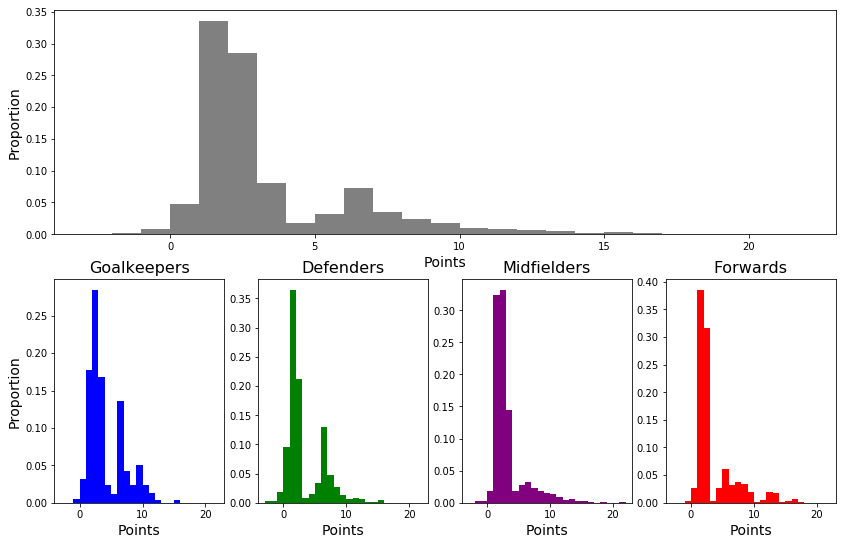

In [15]:
fig = plt.figure(figsize=(14,14))

ax_all = plt.subplot2grid((3,4), (0,0), colspan=4)
ax_gkp = plt.subplot2grid((3,4), (1,0))
ax_def = plt.subplot2grid((3,4), (1,1))
ax_mid = plt.subplot2grid((3,4), (1,2))
ax_for = plt.subplot2grid((3,4), (1,3))

ax_all.hist(players_train.loc[players_train['played_at_all'],'target_total_points'].dropna(),
            bins=nbins, color='grey', density=True)
ax_gkp.hist(players_train.loc[(players_train['position']=='GKP') &
                            (players_train['played_at_all']),'target_total_points'].dropna(),
            bins=nbins, color='blue', density=True)
ax_def.hist(players_train.loc[(players_train['position']=='DEF') &
                            (players_train['played_at_all']),'target_total_points'].dropna(),
            bins=nbins, color='green', density=True)
ax_mid.hist(players_train.loc[(players_train['position']=='MID') &
                            (players_train['played_at_all']),'target_total_points'].dropna(),
            bins=nbins, color='purple', density=True)
ax_for.hist(players_train.loc[(players_train['position']=='FWD') &
                            (players_train['played_at_all']),'target_total_points'].dropna(),
            bins=nbins, color='red', density=True)

ax_gkp.set_title('Goalkeepers', fontsize=16)
ax_def.set_title('Defenders', fontsize=16)
ax_mid.set_title('Midfielders', fontsize=16)
ax_for.set_title('Forwards', fontsize=16)

for ax in [ax_all, ax_gkp, ax_def, ax_mid, ax_for]:
    ax.set_xlim(min_points, max_points)
    ax.set_xlabel('Points', fontsize=14)

ax_all.set_ylabel('Proportion', fontsize=14)
ax_gkp.set_ylabel('Proportion', fontsize=14)

plt.show()

The bimodality is even clearer. Looking at this, it might be useful to perform binary classification on whether or not a player will get more than 4 points in a game. We do have the issue of unbalanced data, but this will be slightly less of an issue if we were to have a variable saying/predicting whether a player is to play.

One of the other options was to use Poisson regression to model the discrete number of points directly. However, we have several problems. From above, players can get negative points and there are many zeros. We also have clear bimodality. Finally, a key assumption of Poisson regression is that the mean and variance of the response are equal. This is not the case with our data:

In [16]:
print('Mean: {:.2f}'.format(players_train.loc[players_train['target_minutes']>0,'target_total_points'].mean()))
print('Variance: {:.2f}'.format(players_train.loc[players_train['target_minutes']>0,'target_total_points'].var()))

Mean: 2.89
Variance: 8.52


We could look into negative binomial regression to address this. However, the multitude of violated assumptions will require lots of effort to overcome, so maybe this is something to focus on at a later date.

For now, I will focus on linear regression and classification approaches. For the latter, I will look to predict whether a player will score 5 or more points in a gameweek, as this seems to be a good split point and also what as a previous fantasy football player I would think is a useful score for a player to get. 

### Categorical variables
First there are a few categorical data columns in our dataset, including a few masquerading as numeric columns. We need to convert these to numeric, the quickest way being to one hot encode them. However, I did have designs on trying out some multilevel models so I will make copies of a few of the originals rather than replace them. Some algorithm implementations (such as Distributed Random Forests in H2O) can handle categorical data directly. Thankfully, the cardinality of encoded columns is not that high so for now I will follow the simple approach. Some of the categorical columns to consider are:

* **position**: o.h.e.
* **team_short**: o.h.e. or try as random effect in a mixed model (though only twenty teams). Another alternative might be to make this ordinal by using position in the league table - however, this would require constructing the table.
* **event_day**: ordinal but no guarantee this varies linearly with the target. As this has only three (or maybe four levels) it is fine to o.h.e.
* **opponent_team_short**: similar to team

Note some of the categorical columns I do not plan to use. For example, kickoff_hour_bin was replaced by the cyclic kickoff_hour_sin and kickoff_hour_cos columns.

Similarly, some of the descriptive columns can be removed such as names/duplicate variables (e.g. team name as team short exists). I will keep player names as a sort of ID for later.

In [17]:
data_types = players_train.dtypes
data_types.sort_values(inplace=True)

columns_categorical = list(data_types[data_types == object].index)

display(columns_categorical)

['prev_kickoff_datetime',
 'first_name',
 'second_name',
 'kickoff_hour_bin',
 'kickoff_time',
 'kickoff_datetime',
 'opponent_team_name',
 'prev_kickoff_hour_bin',
 'team_short',
 'team_name',
 'prev_kickoff_time_formatted',
 'position',
 'opponent_team_short',
 'prev_kickoff_time']

In [18]:
columns_to_delete = ['kickoff_hour_bin',
                     'kickoff_datetime',
                     'prev_kickoff_hour_bin',
                     'prev_kickoff_time_formatted',
                     'prev_kickoff_datetime',
                     'opponent_team_name',
                     'prev_kickoff_time',
                     'kickoff_time',
                     'team_name',
                     ]

columns_categorical = [col for col in columns_categorical if col not in columns_to_delete]

players_train.drop(columns=columns_to_delete, inplace=True)
players_test.drop(columns=columns_to_delete, inplace=True)

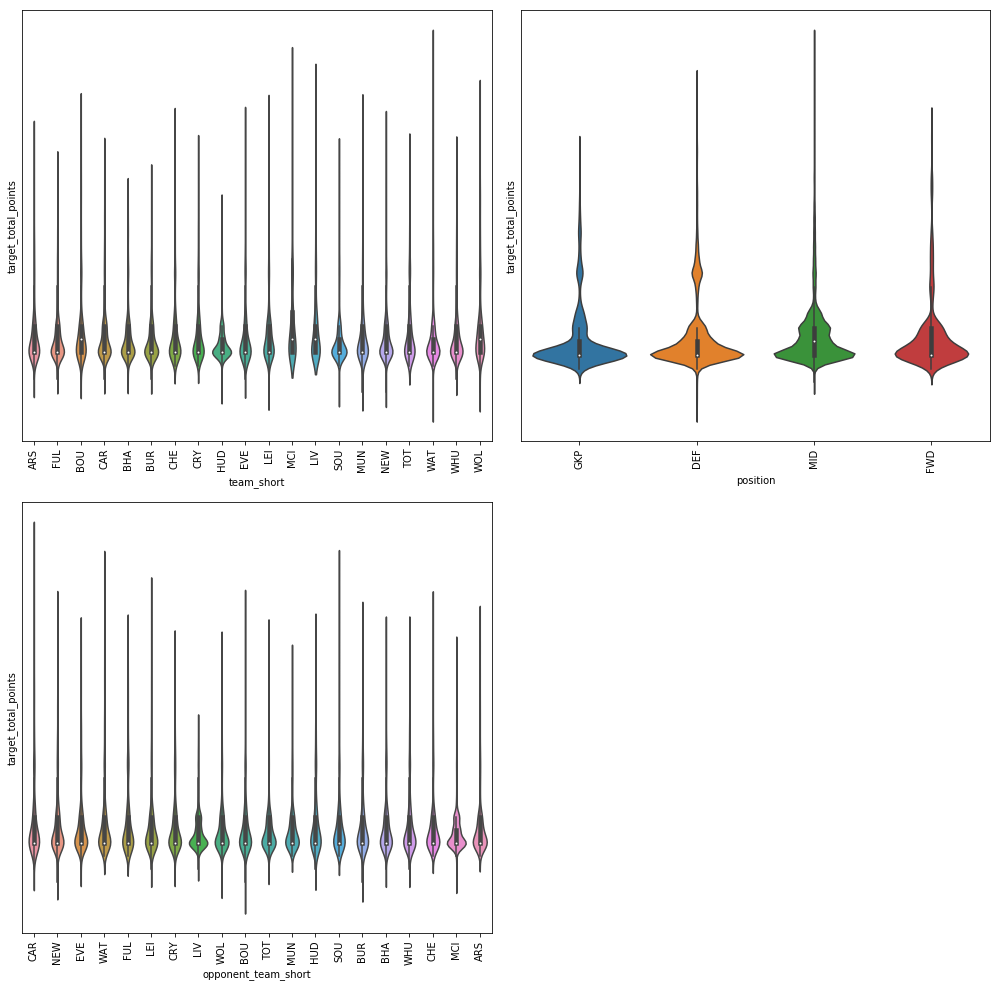

In [19]:
import seaborn as sns

cat_cols_analyse = [col for col in columns_categorical if col not in ['first_name', 'second_name']]

n_cols = 2
n_rows = int(np.ceil(len(columns_categorical) / n_cols))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(14, 20))

for a in ax.ravel():
     a.set_yticks([])

# Create a violinplot for each categorical variable and its relationship with the response        
id_row = 0
id_col = 0
for i, sp in enumerate(cat_cols_analyse):
    
    n_unq = len(players_train[sp].unique())
    
    if n_unq >= 21:
        ax[id_row, id_col].set_xticks([])
        ax[id_row, id_col].set_xticklabels([])
    else:
        for tick in ax[id_row, id_col].get_xticklabels():
            tick.set_rotation(90)

    sns.violinplot(x=sp, y='target_total_points', data=players_train, ax=ax[id_row, id_col])
    
    # update row and column count
    if id_col == n_cols - 1:
        id_row += 1
        id_col = 0
    else:
        id_col += 1
    
# Remove any axes for unneeded subplots
for k in np.arange(i - 1, n_rows * n_cols - 2):
    
    fig.delaxes(ax[id_row, id_col])
    
    # update row and column count
    if id_col == n_cols - 1:
        id_row += 1
        id_col = 0
    else:
        id_col += 1
                
plt.tight_layout()
plt.show()

In [20]:
columns_to_ohe = ['position',
                 'team_short',
                 'event_day',
                 'opponent_team_short']

columns_no_model = ['first_name', 'second_name']

multlvl_cols_train = players_train[['player_id', 'gameweek', 'first_name', 'second_name'] + columns_to_ohe].copy()
multlvl_cols_test = players_test[['player_id', 'gameweek', 'first_name', 'second_name'] + columns_to_ohe].copy()

train_length = players_train.shape[0]
ohe_full_set = pd.concat((players_train[columns_to_ohe], players_test[columns_to_ohe]))
combined_ohe = pd.get_dummies(ohe_full_set, drop_first=True)
ohe_train = combined_ohe.iloc[:train_length, :]
ohe_test = combined_ohe.iloc[train_length:, :]

players_train = pd.concat((players_train.drop(columns=columns_to_ohe), ohe_train), axis=1)
players_test = pd.concat((players_test.drop(columns=columns_to_ohe), ohe_test), axis=1)

In [21]:
players_train.head()

,player_id,first_name,second_name,team_id,team_difficulty,gameweek,kickoff_hour,kickoff_hour_cos,kickoff_hour_sin,kickoff_weekday,kickoff_weekday_cos,kickoff_weekday_sin,fixture_id,is_home,opponent_team,opponent_team_strength,opponent_difficulty,opponent_strength_ha_overall,opponent_strength_ha_attack,opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,value,value_change,custom_form,transfers_balance,transfers_in,transfers_out,team_strength,team_strength_ha_overall,team_strength_ha_attack,team_strength_ha_defence,prev_assists,prev_attempted_passes,prev_big_chances_created,prev_big_chances_missed,prev_bonus,prev_bps,prev_clean_sheets,prev_clearances_blocks_interceptions,prev_completed_passes,prev_creativity,prev_draw,prev_dribbles,prev_errors_leading_to_goal,prev_errors_leading_to_goal_attempt,prev_fouls,prev_goals_conceded,prev_goals_scored,prev_ict_index,prev_influence,prev_key_passes,prev_kickoff_hour,prev_kickoff_hour_cos,prev_kickoff_hour_sin,prev_kickoff_weekday,prev_kickoff_weekday_cos,prev_kickoff_weekday_sin,prev_loss,prev_minutes,prev_offside,prev_open_play_crosses,prev_opponent_score,prev_opponent_team,prev_own_goals,prev_penalties_conceded,prev_penalties_missed,prev_penalties_saved,prev_recoveries,prev_red_cards,prev_saves,prev_tackled,prev_tackles,prev_target_missed,prev_team_score,prev_threat,prev_total_points,prev_win,prev_winning_goals,prev_yellow_cards,roll_goals_scored,roll_mean_points,roll_minutes,roll_team_conceded,roll_team_points,roll_team_scored,roll_total_points,roll_unique_scorers,team_prev_mean_points,team_prev_result_points,team_prev_total_points,team_prev_unique_scorers,use_row,predict_row,model_row,played_at_all,event_day,position_FWD,position_GKP,position_MID,team_short_BHA,team_short_BOU,team_short_BUR,team_short_CAR,team_short_CHE,team_short_CRY,team_short_EVE,team_short_FUL,team_short_HUD,team_short_LEI,team_short_LIV,team_short_MCI,team_short_MUN,team_short_NEW,team_short_SOU,team_short_TOT,team_short_WAT,team_short_WHU,team_short_WOL,opponent_team_short_BHA,opponent_team_short_BOU,opponent_team_short_BUR,opponent_team_short_CAR,opponent_team_short_CHE,opponent_team_short_CRY,opponent_team_short_EVE,opponent_team_short_FUL,opponent_team_short_HUD,opponent_team_short_LEI,opponent_team_short_LIV,opponent_team_short_MCI,opponent_team_short_MUN,opponent_team_short_NEW,opponent_team_short_SOU,opponent_team_short_TOT,opponent_team_short_WAT,opponent_team_short_WHU,opponent_team_short_WOL
3,1,Petr,Cech,1,2,4,12,-1.000000,1.224647e-16,6,0.623490,-0.781831,33,False,5,2.0,4,1080.0,1060.0,1090.0,1.0,90.0,0.0,2.0,123566.0,50.0,0.0,22.333333,9582.0,19332.0,9750.0,4.0,1320.0,1270.0,1340.0,0.0,24.0,0.0,0.0,0.0,17.0,0.0,0.0,20.0,0.0,False,0.0,0.0,0.0,0.0,1.0,0.0,2.8,27.8,0.0,14.0,-0.866025,-5.000000e-01,5.0,-0.222521,-0.974928,False,90.0,0.0,0.0,1.0,19.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,3.0,True,0.0,0.0,0.0,2.380952,90.0,2.000000,1.0,1.666667,33.333333,1.333333,3.357143,3.0,47.0,2.0,True,False,True,True,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,Petr,Cech,1,3,5,14,-0.866025,-5.000000e-01,5,-0.222521,-0.974928,46,False,15,3.0,4,1120.0,1110.0,1050.0,2.0,90.0,0.0,1.0,123310.0,50.0,0.0,17.000000,-3297.0,8837.0,12134.0,4.0,1320.0,1270.0,1340.0,0.0,38.0,0.0,0.0,0.0,8.0,0.0,0.0,24.0,0.0,True,0.0,0.0,2.0,0.0,2.0,0.0,0.2,2.4,0.0,12.0,-1.000000,1.224647e-16,6.0,0.623490,-0.781831,False,90.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,False,0.0,0.0,0.0,3.000000,90.0,2.000000,2.0,2.666667,42.000000,2.333333,3.214286,3.0,45.0,3.0,True,False,True,True,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,1,Petr,Cech,1,2,6,15,-0.707107,-7.071068e-01,6,0.623490,-0.781831,51,True,8,3.0,4,1090.0,1070.0,1140.0,11.0,90.0,0.0,0.0,124787.0,50.0,0.0,12.666667,-797.0,6593.0,7390.0,4.0,1260.0,1240.0,1310.0,0.0,33.0,0.0,0.0,0.0,13.0,0.0,2.0,23.0,0.0,True,0.0,

### Numeric variables

In [22]:
columns_numerical = list(data_types[(data_types != object) &
                                    ~data_types.index.isin(columns_target_all +
                                                           ['predict_row', 'use_row'] +
                                                          no_model_cols)].index)

In [23]:
print(columns_numerical)

['played_at_all', 'prev_win', 'prev_loss', 'model_row', 'prev_draw', 'is_home', 'opponent_difficulty', 'opponent_team', 'fixture_id', 'event_day', 'kickoff_weekday', 'player_id', 'team_id', 'kickoff_hour', 'gameweek', 'team_difficulty', 'prev_recoveries', 'prev_penalties_saved', 'prev_penalties_missed', 'prev_penalties_conceded', 'prev_own_goals', 'prev_opponent_team', 'prev_opponent_score', 'prev_open_play_crosses', 'prev_offside', 'kickoff_hour_sin', 'prev_red_cards', 'prev_kickoff_weekday_sin', 'prev_kickoff_weekday_cos', 'prev_kickoff_weekday', 'prev_kickoff_hour_sin', 'prev_kickoff_hour_cos', 'prev_kickoff_hour', 'prev_key_passes', 'prev_minutes', 'prev_saves', 'prev_tackles', 'prev_ict_index', 'team_prev_unique_scorers', 'team_prev_total_points', 'team_prev_result_points', 'team_prev_mean_points', 'roll_unique_scorers', 'roll_total_points', 'roll_team_scored', 'roll_team_points', 'prev_tackled', 'roll_team_conceded', 'roll_mean_points', 'roll_goals_scored', 'prev_yellow_cards', '

In [24]:
correlations = players_train.loc[:, columns_numerical + ['target_total_points']].corr()
correlations_with_target = correlations.loc[:, 'target_total_points']
print('Most positively correlated variables with the target_total_points response:')
correlations_with_target
display(correlations_with_target.drop('target_total_points').sort_values(ascending=False).head(10))
print('\n\nMost negatively correlated variables with the target_total_points response:')
display(correlations_with_target.sort_values(ascending=False).tail(10))

Most positively correlated variables with the target_total_points response:


played_at_all            0.582582
roll_minutes             0.463250
prev_minutes             0.449062
custom_form              0.437085
prev_bps                 0.374002
prev_ict_index           0.373000
prev_recoveries          0.361215
prev_attempted_passes    0.360746
prev_influence           0.349874
prev_total_points        0.349752
Name: target_total_points, dtype: float64



Most negatively correlated variables with the target_total_points response:


prev_loss                      -0.027723
fixture_id                     -0.038075
gameweek                       -0.038091
player_id                      -0.072898
opponent_strength_ha_defence   -0.081624
opponent_team_strength         -0.081987
team_difficulty                -0.086532
opponent_strength_ha_overall   -0.086925
opponent_strength_ha_attack    -0.087202
model_row                            NaN
Name: target_total_points, dtype: float64

It looks like, similar to earlier, we need to take into account whether a player plays at all. It might make sense to produce a model to predict this and only use those players who did play to build the points classifier.

In [25]:
correlations = players_train.loc[players_train.played_at_all, columns_numerical + ['target_total_points']].corr()
correlations_with_target = correlations.loc[:, 'target_total_points']
print('Most positively correlated variables with the target_total_points response:')
correlations_with_target
display(correlations_with_target.drop('target_total_points').sort_values(ascending=False).head(10))
print('\n\nMost negatively correlated variables with the target_total_points response:')
display(correlations_with_target.sort_values(ascending=False).tail(10))

Most positively correlated variables with the target_total_points response:


value                0.210346
selected             0.193421
custom_form          0.161339
roll_minutes         0.153658
prev_ict_index       0.145117
prev_minutes         0.140283
transfers_in         0.136135
prev_threat          0.133053
prev_total_points    0.132560
transfers_out        0.129897
Name: target_total_points, dtype: float64



Most negatively correlated variables with the target_total_points response:


roll_team_conceded             -0.034191
player_id                      -0.034654
prev_loss                      -0.043031
opponent_team_strength         -0.145738
opponent_strength_ha_defence   -0.146548
opponent_strength_ha_attack    -0.154777
team_difficulty                -0.155232
opponent_strength_ha_overall   -0.156042
played_at_all                        NaN
model_row                            NaN
Name: target_total_points, dtype: float64

These coefficients are lower than I hoped for, and may be evidence that this will be a tricky problem where we may suffer from some underfitting. However, these results are based on linear relationships which in our data could be non-linear. Now it's time to plot them. As there are quite a few numeric columns, I will split them up.

In [26]:
def plot_relationships(correlations, data, features, nrows=1, ncols=1, refline_y=4):
    
    # sort correlations descending
    correlations = correlations.filter(features).sort_values(ascending=False)
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(16,16))
    count_row = 0
    count_col = 0

    for a in ax.ravel():
        a.set_xticks([])
        a.set_yticks([])

    # For each feature
    for i, sp in enumerate(correlations.iteritems()):
        
        # If not enough rows or columns given, do not attempt to produce plot
        if i >= nrows*ncols:
            break
            
        # title of each subplot is the feature name and the correlation
        title = sp[0] + ': {:.2f}'.format(sp[1])

        x_vals = data[sp[0]]
        y_vals = data['target_total_points']
        ax[count_row, count_col].scatter(x_vals, y_vals, c='lightblue', marker='s', s=8, alpha=0.2)
        ax[count_row, count_col].set_title(title, fontsize=10)
        ax[count_row, count_col].axhline(y=refline_y, color='red')

        # update row and column count
        if count_col == ncols - 1:
            count_row += 1
            count_col = 0
        else:
            count_col += 1

    plt.show()

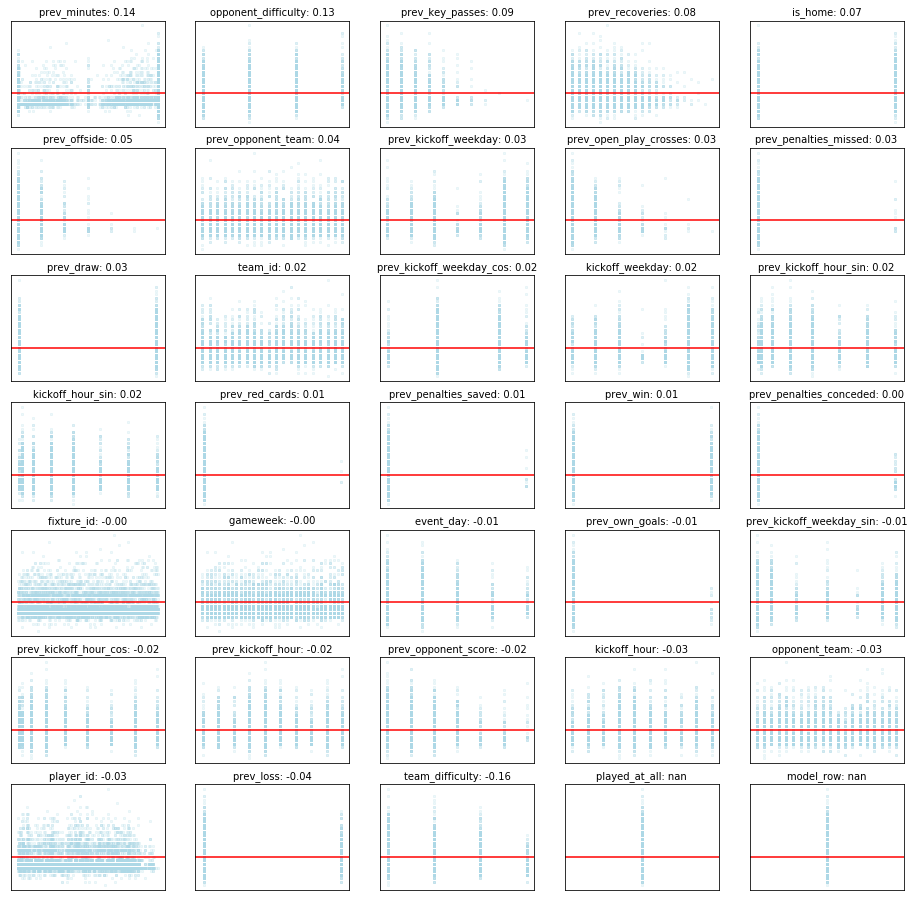

In [27]:
plot_relationships(correlations_with_target.drop('target_total_points'),
                   players_train.loc[(players_train['played_at_all'])],
                   columns_numerical[:35],
                   nrows=7,
                   ncols=5)

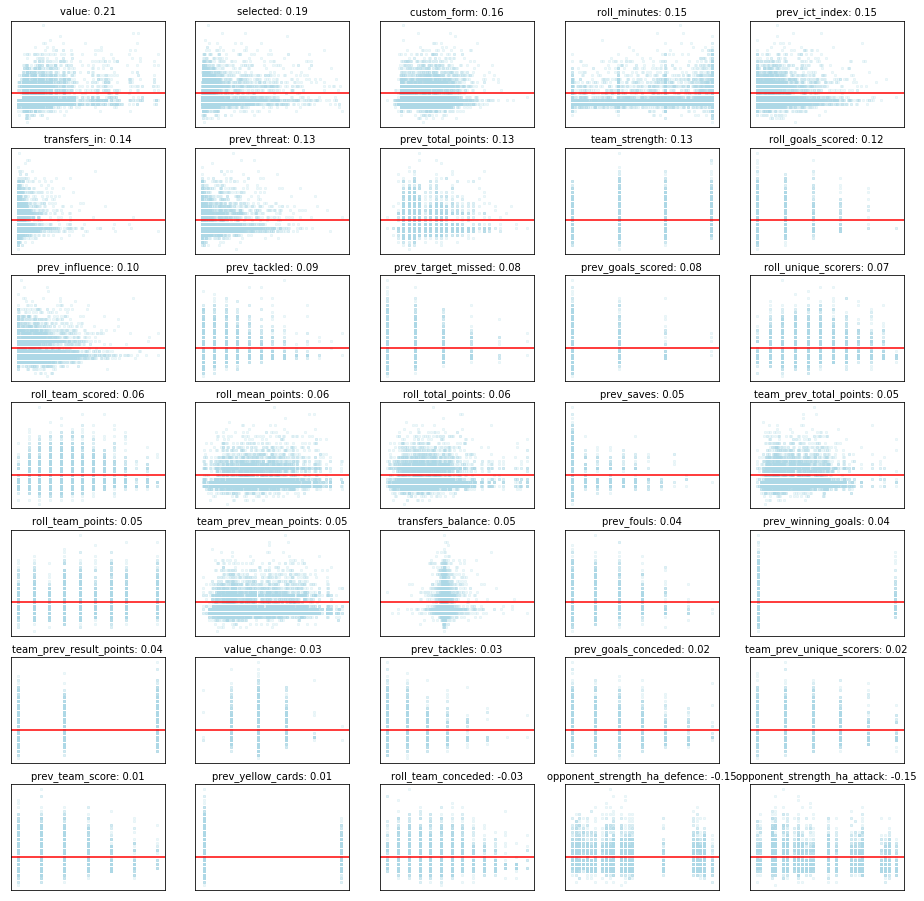

In [28]:
plot_relationships(correlations_with_target.drop('target_total_points'),
                   players_train.loc[(players_train['played_at_all'])],
                   columns_numerical[35:70],
                   nrows=7,
                   ncols=5)                         

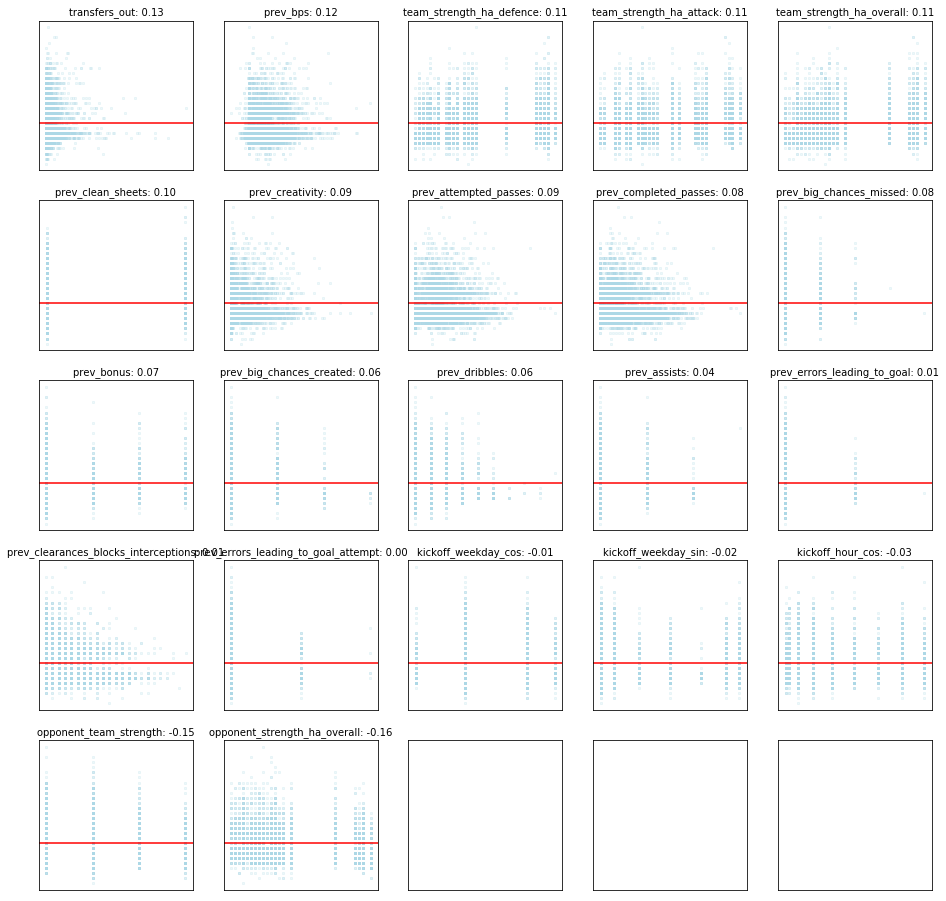

In [29]:
plot_relationships(correlations_with_target.drop('target_total_points'),
                   players_train.loc[(players_train['played_at_all'])],
                   columns_numerical[70:len(columns_numerical)],
                   nrows=5,
                   ncols=5)

This might be a challenging problem for a couple or reasons. Firstly, we have a lot of non-linear relationships in our data. We might be able to help with this by taking transforms of our features and response. However, we have negative and zero values for some (including the response), meaning log-transforms for instance will be difficult. Secondly, even if we were to use classification approach, the red reference lines at points=5 do not appear to show any clear separation in the data for any of the features. As a result, we should be aware that our model will be far from perfect!

## Approach
From the above analysis, we see that this might be a somewhat difficult problem due to the relationships between each feature and the number of points. As a result, my approach will be based around predicting whether five or more points will be scored (unbalanced classification), training on data of players who played in a match. I will make another model for whether a player will play any minutes. If I have time, I will look into performing linear regression to predict the number of points. Alternatively, I might look into some variant of Poisson regression (after attempting to remedy issues such as overdispersion).

With that in mind, let's look at some of the features in more detail and do some cleaning.

### Adding a new target column for classification

In [30]:
players_train.loc[players_train.model_row, 'target_ge5'] = \
        players_train.loc[players_train.model_row, 'target_total_points'] >= 5
players_test.loc[players_test.model_row, 'target_ge5'] = \
        players_test.loc[players_test.model_row, 'target_total_points'] >= 5

### Missing values
We have already done some analysis, but again I will check for any missing values.

In [31]:
missing_train = players_train.isna().sum().sort_values(ascending=False)
missing_train = missing_train[missing_train > 0]
display(missing_train)

target_ge5               491
target_total_points      491
target_minutes           491
target_goals_scored      491
target_goals_conceded    491
dtype: int64

This shows that are our only missing columns are the targets we are trying to predict for the latest gameweek.

### Add selected variable(s)
During the data preparation there was one additional feature which came to mind which I have not yet added: a more appropriate measure of the number of FPL player teams containing each player. This exists as the variable 'selected', however each gameweek there are different numbers of teams entered into the competition which means that our assumption that each gameweek is considered 'equal' breaks down. While this assumption is imperfect anyway (double gameweeks, player transfers, teams playing in other competitions etc.), over the course of the season the player base increases dramatically. As a result, a 'scaled' version of the selected variable is required. We don't have the weekly player base size so we cannot reconstruct a weekly selected-by percentage.

There are two aproaches which come to mind; I will try both and see which is better related to the response. Note that here I will only construct the class/function to perform this action; the actual calculations will need to be done in each fold of the cross validation process to avoid data leakage.

Firstly, calculate the percentiles of the selected variable for each gameweek on the training data only. See which percentile each player gameweek observation fits into based on its selected variable (for each of the train, validation, and test datasets).

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class SelectedPercentiles(BaseEstimator, TransformerMixin):
    
    def __init__(self, by_group='gameweek', variable='selected'):
        self.by_group = by_group
        self.variable = variable
    
    def fit(self, X):
        """Determine the percentile values for each by-group in the data for a variable. Create another data
        set with the upper and lower bounds for each by-group's possible percentile."""
        use_dtype = X[self.by_group].dtype
        self.quants = X.groupby(self.by_group)[self.variable].quantile(
            [0.1*round(i/10, 2) for i in range(100)]).reset_index().rename(columns={'level_1':'percentile',
                                    self.variable:'lower_bound'})
        self.quants['upper_bound'] = self.quants.groupby(self.by_group)['lower_bound'].shift(-1).fillna(99999999)
        self.quants[self.by_group] = self.quants[self.by_group].astype(use_dtype)
    
    def transform(self, X, drop_bounds=True):
        """Add to the dataset the percentile at which each player is in for a variable, for the appropriate
        by-groups."""
        X2 = X.copy()
        # Note that this method can be a bit unnecessarily memory-intensive
        X2 = X2.merge(self.quants, on=self.by_group)
        X2 = X2[(X2[self.variable] >= X2['lower_bound']) &
                (X2[self.variable] < X2['upper_bound'])]
        if drop_bounds:
            X2.drop(columns=['lower_bound', 'upper_bound'], inplace=True)
        return X2
    
    def fit_transform(self, X, drop_bounds=True):
        self.fit(X)
        return self.transform(X, drop_bounds=drop_bounds)

In [33]:
sp = SelectedPercentiles()
x = players_train.copy()
x = sp.fit_transform(players_train, drop_bounds=True).rename(columns={'percentile': 'selected_percentile'})


The alternative is to simply standardise the selected variable independently for each gameweek. Again, the parameters are derived from the training data only.

In [34]:
def get_std_params(data, by_group='gameweek', variable='selected'):
    use_dtype = data[by_group].dtype
    vals = data.groupby(by_group)[variable].agg(['mean','std']).reset_index()
    vals.rename(columns={'mean': variable + '_mean',
                         'std': variable + '_std'}, inplace=True)
    vals[by_group] = vals[by_group].astype(use_dtype)
    return vals

gw_selected_stats = get_std_params(x)

x = x.merge(gw_selected_stats, how='left', on='gameweek')
x['selected_stand'] = (x['selected'] - x['selected_mean']) / x['selected_std']
x.drop(columns=['selected_mean','selected_std'], inplace=True)

# Show a few examples for the first players. Include the 'percentile selected' variable for comparison.
x.loc[x['gameweek']==12,
               ['player_id', 'gameweek', 'selected', 'selected_percentile', 'selected_stand']].head(10)

,player_id,gameweek,selected,selected_percentile,selected_stand
3443,1,12,85826.0,0.69,-0.203079
3444,2,12,99308.0,0.72,-0.162473
3445,3,12,5911.0,0.21,-0.443773
3446,6,12,48849.0,0.59,-0.314449
3447,7,12,79573.0,0.68,-0.221912
3448,8,12,18850.0,0.43,-0.404802
3449,9,12,50590.0,0.60,-0.309205
3450,10,12,6010.0,0.22,-0.443475
3451,11,12,54009.0,0.61,-0.298908
3452,12,12,65145.0,0.64,-0.265368


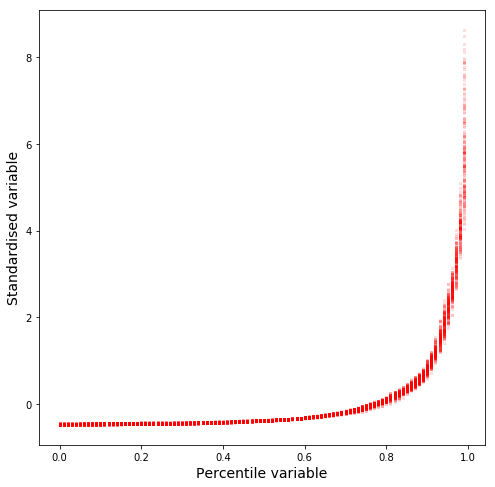

In [35]:
fig, ax = plt.subplots(1, figsize=(8, 8))
x.plot.scatter(x='selected_percentile', y='selected_stand', alpha=0.1, s=2, marker='s', color='red', ax=ax)
ax.set_xlabel('Percentile variable', fontsize=14)
ax.set_ylabel('Standardised variable', fontsize=14)
plt.show()

The relationship above for our two newly created variables is likely due to the fact that there are few players which are very popular, with a long tail of players which are rarely selected. In other words our distribution of selected is very positively skewed. As expected (ignoring the discontinous nature of the percentile variable), the relationship is monotonic.

In [36]:
class StdSelectedGw(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_groups=0, col_var=1):
        self.col_groups = col_groups
        self.col_var = col_var
        
    def fit(self, X, y=None):
        inp = pd.DataFrame(X[:, [self.col_groups, self.col_var]], columns=['group', 'var'])
        self.means_ = inp.groupby('group')['var'].mean().reset_index().rename(columns={'var': 'mean'})
        self.stds_ = inp.groupby('group')['var'].std().reset_index().rename(columns={'var': 'std'})
        return self
    
    def transform(self, X):
        outp = pd.DataFrame(X[:, [self.col_groups, self.col_var]], columns=['group', 'var'])
        outp = outp.merge(self.means_, on='group', how='left')
        outp = outp.merge(self.stds_, on='group', how='left')
        outp['new'] = (outp['var'] - outp['mean'])/outp['std']
        X = np.append(X, np.expand_dims(outp['new'].values, axis=1), axis=1)
        return X

## Analysing outliers
The next step is to attempt to remove any outliers in the data. I will plot box plots for each of the features. Due to the scaling of each feature, I will split the figures depending on the log10 value of each feature's maximum value. This is so features which have values over a short range can be interpreted.

In [37]:
col_maxes = pd.DataFrame(players_train[columns_numerical].max().sort_values(ascending=False).astype(float))

col_maxes['log_scale'] = np.where(np.isfinite(col_maxes), np.ceil(np.log10(col_maxes)), 0)

def show_outliers(column_scales, data, logscale):
    features_logscale = list(col_maxes.loc[col_maxes.log_scale == logscale].index)
    if len(features_logscale) > 0:
        fig, ax = plt.subplots(1, figsize=(16, 8))
        data.filter(features_logscale, axis=1).boxplot(ax=ax, rot=90)
        plt.title('Log10 scale of {}'.format(logscale), fontsize=14)
        ax.set_xlabel('Feature name', fontsize=14)
        ax.set_ylabel('Values', fontsize=14)
        plt.show()
        
print('Minimum logscale value: {}'.format(col_maxes['log_scale'].min()))
print('Maximum logscale value: {}'.format(col_maxes['log_scale'].max()))

Minimum logscale value: -0.0
Maximum logscale value: 7.0


In [38]:
n_per_logscale = col_maxes['log_scale'].value_counts().sort_index()
print(n_per_logscale)

0.0    22
1.0    34
2.0    16
3.0    10
4.0     6
7.0     4
Name: log_scale, dtype: int64


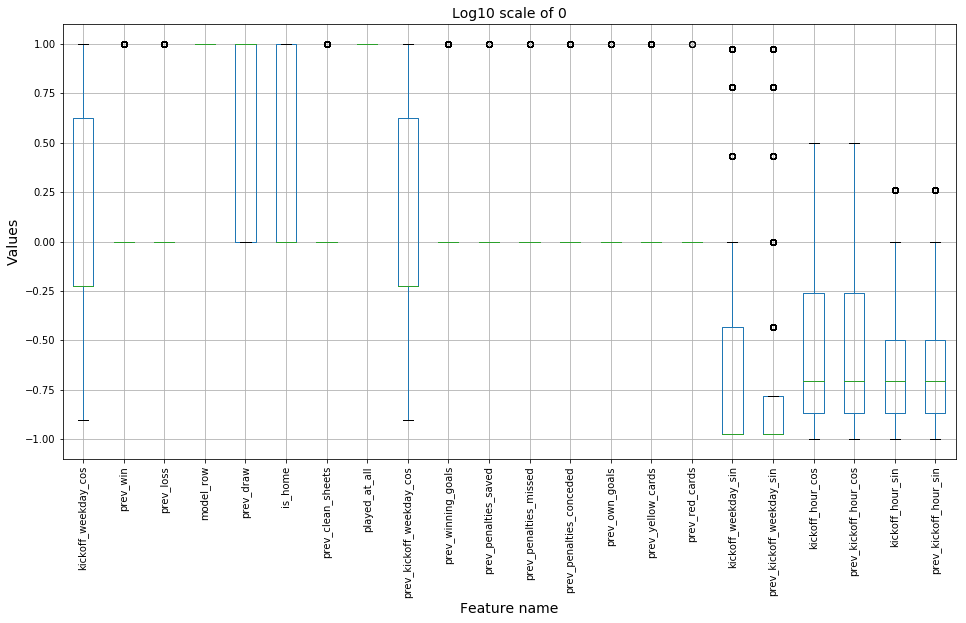

In [39]:
show_outliers(col_maxes, players_train.loc[players_train.played_at_all], 0)

Nothing too worrying here; a fair few of these variables are boolean (so this sort of plot is not too informative), or naturally have values in the set {0, 1} (e.g. previous yellow cards). The day variables (and times to an extent) can be explained by the fact most games are on the weekend.

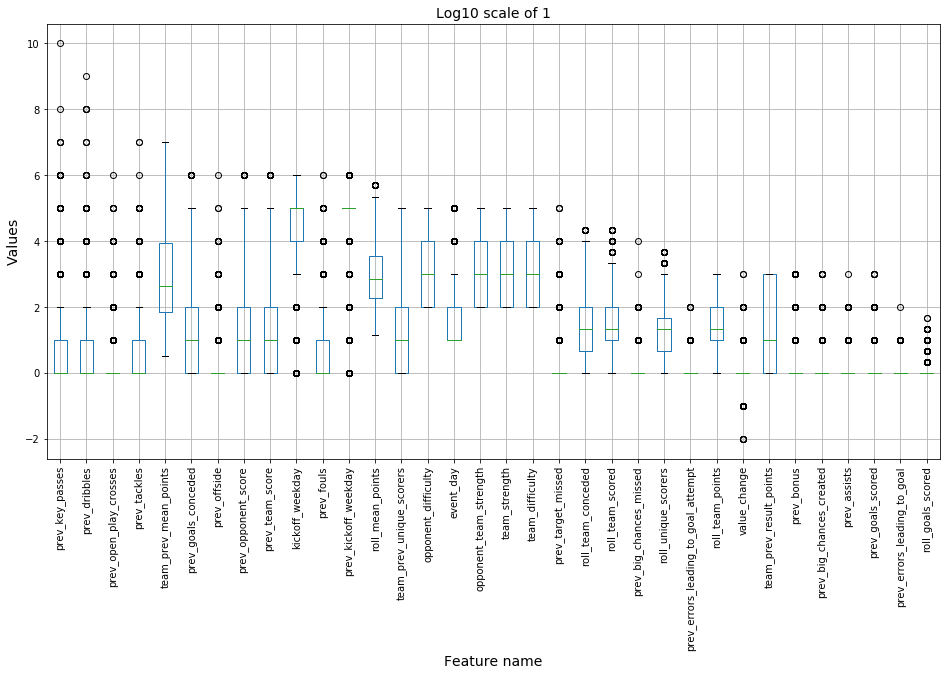

In [40]:
show_outliers(col_maxes, players_train.loc[players_train.played_at_all], 1)

For these features, I am also not too worried. They are typically ordinal or discrete counts.

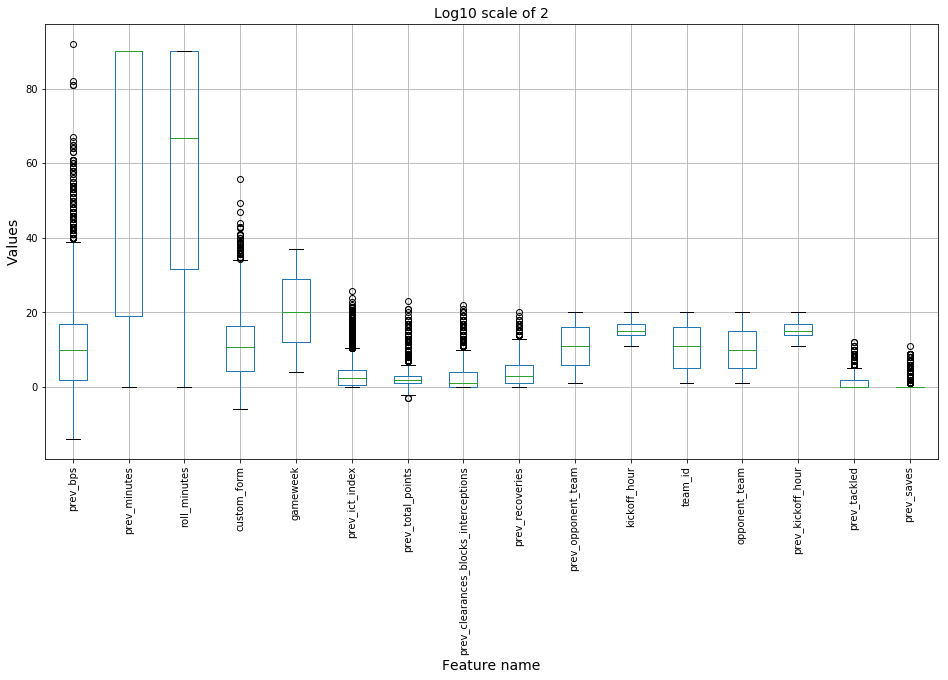

In [41]:
show_outliers(col_maxes, players_train.loc[players_train.played_at_all], 2)

These features are similar to the above, where 'outliers' above the box plot would be expected to be beneficial to a model as they may well be good predictors of the number of points scored.

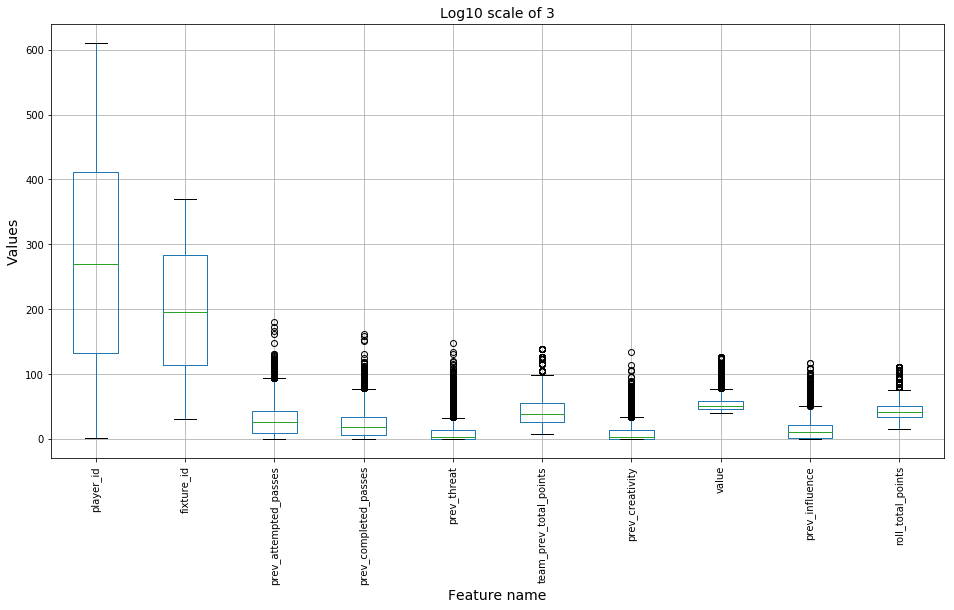

In [42]:
show_outliers(col_maxes, players_train.loc[players_train.played_at_all], 3)

Again, this is a similar situation.

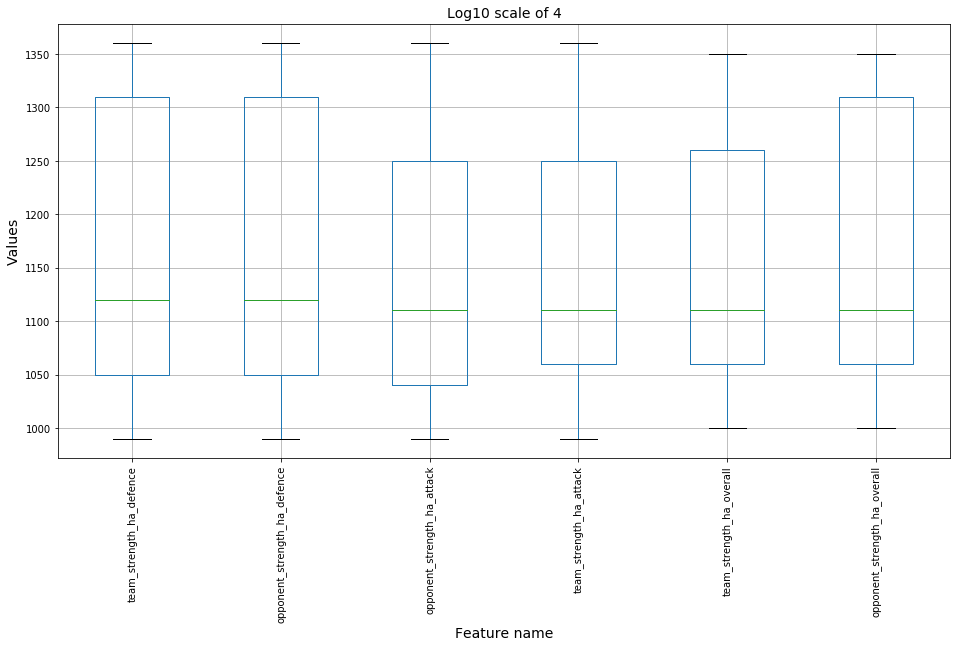

In [43]:
show_outliers(col_maxes, players_train.loc[players_train.played_at_all], 4)

And again.

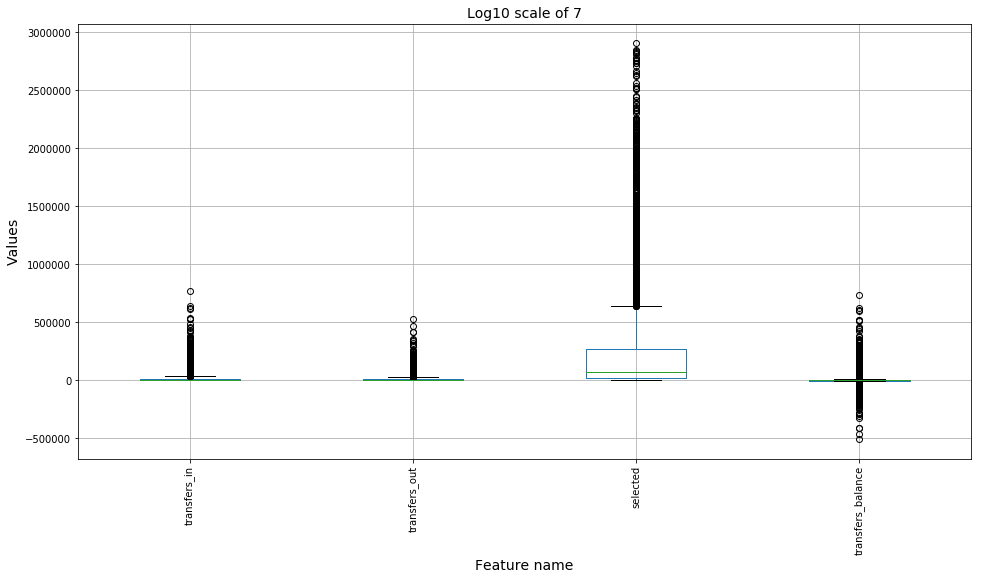

In [44]:
show_outliers(col_maxes, players_train.loc[players_train.played_at_all], 7)

Note that most players will not be transferred much as they will either not be playing much (and hence not in anyone's team!), or will not be a fashionable target/player that needs to be got rid of.

My main reason for checking outliers was to ensure there are no erroneous values. This seems not to be the case; outliers appear to normally be from when players have performed well (or badly), which we would expect to be correlated with the target.

## Assessing correlation amongst features
Another assumption of many algorithms is that features are not overly correlated with each other. In this section I will look at bivariate correlations between features and highlight which may cause the biggest issues.

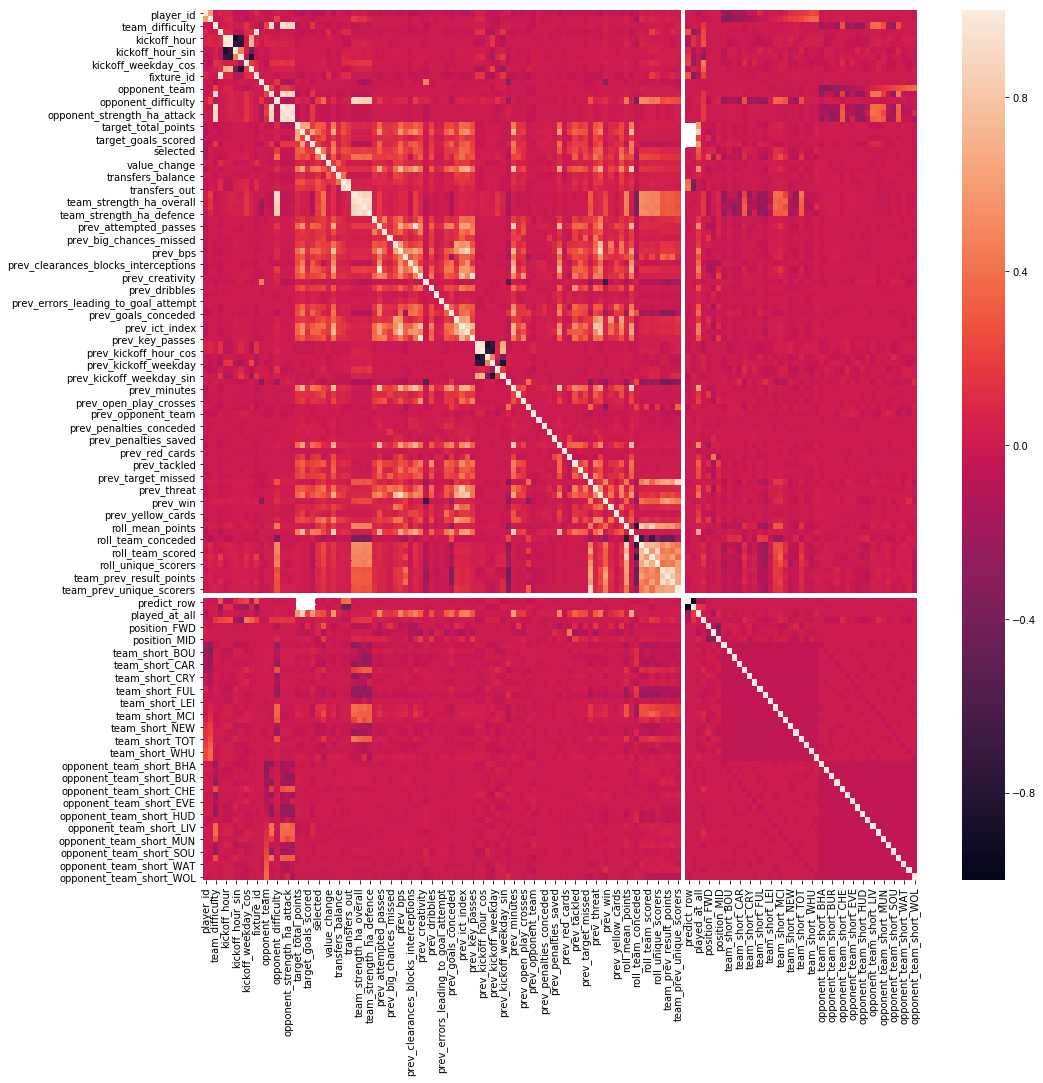

In [45]:
feature_correlation = players_train.corr()
import seaborn as sns
fig, ax = plt.subplots(1, figsize=(16, 16))
sns.heatmap(feature_correlation, ax=ax)
plt.show()

Here I convert this matrix to a column representation of the pairwise correlations between features to make this easier to explore.

In [46]:
feature_correlation_long = feature_correlation.stack().reset_index().rename(columns={'level_0': 'feature1',
                                                                                     'level_1': 'feature2',
                                                                                     0: 'correlation_coefficient'})
feature_correlation_long = feature_correlation_long[feature_correlation_long.feature1 != feature_correlation_long.feature2]
feature_correlation_long.sample(10)

,feature1,feature2,correlation_coefficient
6155,prev_dribbles,team_prev_total_points,0.012490
3423,value_change,opponent_team_short_BHA,0.024064
17032,opponent_team_short_CHE,prev_target_missed,0.020909
13469,position_FWD,position_MID,-0.330200
11627,roll_team_conceded,prev_draw,0.047888
16166,team_short_WHU,prev_big_chances_missed,-0.016215
15943,team_short_TOT,team_prev_mean_points,0.097720
18694,opponent_team_short_WAT,prev_yellow_cards,0.003498
4606,prev_assists,prev_minutes,0.202278
11415,roll_mean_points,team_short_FUL,-0.179123


For now, I will use a (somewhat arbitrary) cut-off of 0.8 to find features which are overly correlated with one another.

In [47]:
feature_correlation_overly = feature_correlation_long.loc[np.abs(feature_correlation_long.correlation_coefficient) >= 0.8].copy()
print('Number of overly correlated features: {:.0f}'.format(feature_correlation_overly.shape[0]/2))

# The correlation matrix above is from a square matrix - below I remove duplicate features
# Get both columns and sort the column values for each row
sorted_feature_cols = feature_correlation_overly[['feature1', 'feature2']].values
sorted_feature_cols.sort()
sorted_feature_cols_df = pd.DataFrame(sorted_feature_cols, columns=['feature1a', 'feature1b'])

# Add the two new feature name columns. As their values are ordered, we can easily remove the duplicates
feature_correlation_overly = pd.concat([feature_correlation_overly.reset_index(),
                                       sorted_feature_cols_df.reset_index()],
                                      axis=1, sort=True, join='inner')

feature_correlation_overly.drop_duplicates(subset=['feature1a', 'feature1b'], inplace=True)
display(feature_correlation_overly.drop(columns=['feature1a', 'feature1b', 'index']).sort_values(
    'correlation_coefficient', ascending=False))

Number of overly correlated features: 47


,feature1,feature2,correlation_coefficient
4,gameweek,fixture_id,0.998280
52,prev_attempted_passes,prev_completed_passes,0.988622
57,prev_creativity,prev_key_passes,0.970879
5,kickoff_hour,kickoff_hour_cos,0.966438
64,prev_kickoff_hour,prev_kickoff_hour_cos,0.965175
23,opponent_strength_ha_overall,opponent_strength_ha_defence,0.946811
1,team_difficulty,opponent_strength_ha_overall,0.946267
43,team_strength_ha_overall,team_strength_ha_defence,0.943218
13,opponent_team_strength,opponent_strength_ha_overall,0.938410
22,opponent_strength_ha_overall,opponent_strength_ha_attack,0.938262


There are a fair few correlated features. This is an issue and goes against many machine learning algorithm assumptions. The obvious fix is to remove these columns (maybe based upon which of the correlated features has a stronger association with the outcome). However, an alternative would be to use principal component analysis to represent our features in a lower-dimensional space which takes into account variables' correlation. I will use this method as it is more data-driven than manually removing correlated features, and much less complicated than writing an algorithm to do this automatically. We would also not need to specify a cut-off (above 80%) to decide whether a pair of features are overly correlated.

To use principal component analysis this needs to be done so as part of the modelling pipeline so that it can be refitted each time for the training data in each cross validation fold.

In [51]:
players_train.to_csv('../data/model_data/final_train_data.csv', index=False)
players_test.to_csv('../data/model_data/final_test_data.csv', index=False)

For the sake of clarity, I will perform the model fitting in a separate Jupyter notebook.